# Autoencoder MNIST Classifier and K-Means Clustering with Hungarian Algorithm

References: 
* Advanced Deep Learning with TensorFlow 2 and Keras by Rowel Atienza, Chapter 3: Autoencoders
* [Autoencoders and multi-stage training for MNIST classification](http://tech.octopus.energy/timeserio/examples/MNIST.html)
* [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import math
import matplotlib.pyplot as plt

### Get the data

In [2]:
# Load the MNIST data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Categorically encode the labels.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the data into the shape the network expects.
x_train = np.reshape(x_train, [-1, 28, 28, 1])
x_test = np.reshape(x_test, [-1, 28, 28, 1])

# Scale the data so that all values are in the [0, 1] interval.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### Encoder model

In [3]:
latent_dim = 2

# Encoder
inputs = Input(shape=(28, 28, 1), name='encoder_input')
x = inputs

x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

# Shape info needed to build decoder model.
shape = x.shape.as_list()

# Generate a 2-dim latent vector.
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1849

### Decoder model

In [4]:
# Decoder
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)

x = Conv2DTranspose(filters=1, kernel_size=3, padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# The decoder model takes in the latent layer and outputs the sigmoid layer.
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)          256 

### Classifier model

![Neural Network](https://storage.googleapis.com/activation-function/images/jupyter/ae-classifier.svg)

<b>Figure 1.</b> Architecture of autoencoder as an image classifier

In [5]:
# Classifier model
latent_inputs = Input(shape=(latent_dim,), name='classifier_input')
x = Dense(512)(latent_inputs)
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.4)(x)
x = Dense(10)(x)
classifier_outputs = Activation('softmax', name='classifier_output')(x)
classifier = Model(latent_inputs, classifier_outputs, name='classifier')
classifier.summary()

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classifier_input (InputLayer [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

We'll now put together a siamese network that outputs two things, a classifier and a decoder. They both take in the encoder model as input, but the layers that they add to the encoder are different. The classifier model adds dense layers and a final softmax layer, while the decoder model adds convolutional layers that are mirror opposite of the encoder convolutional layers.

Model: "autodecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 2)            72034       encoder_input[0][0]              
                                                                 encoder_input[0][0]              
__________________________________________________________________________________________________
classifier (Functional)         (None, 10)           135434      encoder[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 28, 28, 1)    112033      encoder[1][0]          

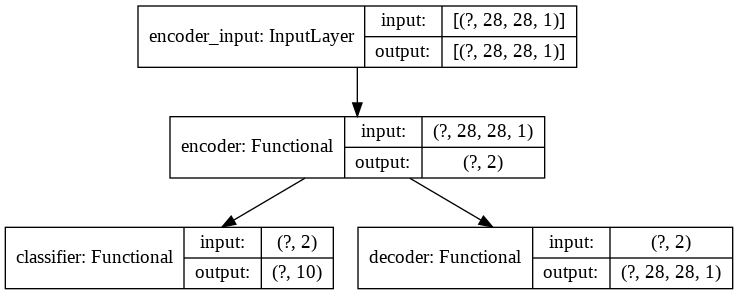

In [6]:
autoencoder = Model(inputs,
                    [classifier(encoder(inputs)), decoder(encoder(inputs))],
                    name='autodecoder')
autoencoder.summary()
plot_model(autoencoder, to_file='classifier-autoencoder.png', show_shapes=True)

In [7]:
# Loss function is categorical_crossentropy for the classifier.
# Loss function is mse for the decoder.
autoencoder.compile(loss=['categorical_crossentropy', 'mse'],
                    optimizer='adam',
                    metrics=['accuracy', 'mse'])

# Train the autoencoder for 25 epochs.
# y_train/y_test are the labels for the classifier output.
# x_train/x_test are the labels for the decoder output.
autoencoder.fit(x_train, [y_train, x_train],                
                validation_data=(x_test, [y_test, x_test]),
                epochs=25, batch_size=128)

Epoch 1/25
469/469 [==============================] - 7s 15ms/step - loss: 0.5707 - classifier_loss: 0.5009 - decoder_loss: 0.0698 - classifier_accuracy: 0.8200 - classifier_mse: 0.0241 - decoder_accuracy: 0.7811 - decoder_mse: 0.0698 - val_loss: 0.2558 - val_classifier_loss: 0.1951 - val_decoder_loss: 0.0606 - val_classifier_accuracy: 0.9312 - val_classifier_mse: 0.0096 - val_decoder_accuracy: 0.7898 - val_decoder_mse: 0.0606
Epoch 2/25
469/469 [==============================] - 7s 14ms/step - loss: 0.2696 - classifier_loss: 0.2156 - decoder_loss: 0.0540 - classifier_accuracy: 0.9309 - classifier_mse: 0.0102 - decoder_accuracy: 0.7942 - decoder_mse: 0.0540 - val_loss: 0.1943 - val_classifier_loss: 0.1419 - val_decoder_loss: 0.0524 - val_classifier_accuracy: 0.9528 - val_classifier_mse: 0.0067 - val_decoder_accuracy: 0.7959 - val_decoder_mse: 0.0524
Epoch 3/25
469/469 [==============================] - 7s 14ms/step - loss: 0.2092 - classifier_loss: 0.1568 - decoder_loss: 0.0524 - class

**Highest val_classifier_accuracy was 0.9784. Not bad.**

Get predictions from the autoencoder siamese network. y_hat is the prediction set of the classifier. x_decoded is the prediction set of the classifier.

In [8]:
y_hat, x_decoded = autoencoder.predict(x_test)
print('y_test:', np.argmax(y_test[:8], axis=1))
print('y_hat: ', np.argmax(y_hat[:8], axis=1))

y_test: [7 2 1 0 4 1 4 9]
y_hat:  [7 2 1 0 4 1 4 9]


8 out of 8 correct predictions. Very nice.

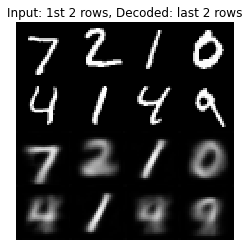

In [9]:
# Display the 1st 8 input and decoded images.
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, 28, 28))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

The decoder outputted images that are very blurry. This is because the latent dimension was super condensed to 2 dimensions in order to later on visualize and cluster the digits. To compensate for this horrific bottleneck layer, the epoch on the fit above had to be moved up to 25. If visualization was not needed, the latent dimension could be changed to 16, and the training will go much faster, and the decoding will be much more accurate. Nevertheless, the ability of the autoencoder model to classify the digits is unaffected.

In [10]:
latent = encoder.predict(x_test)
print(latent.shape)
print(latent[0])

(10000, 2)
[28.819323 39.25298 ]


### Visualize the digit clusters

In [11]:
# Get the original y_test prior to one-hot encoding.
y_test_original = np.argmax(y_test, axis=1)
y_test_original.shape

(10000,)

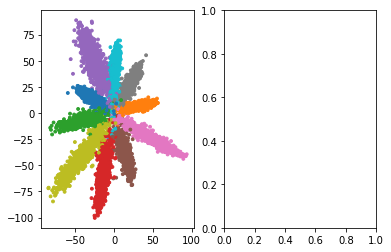

In [12]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(latent[:,0], latent[:,1],
	c=y_test_original, s=8, cmap='tab10')

# Use K-means to cluster the feature vectors

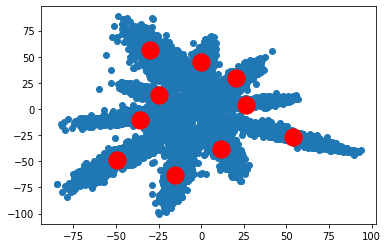

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(latent)
plt.scatter(latent[:,0], latent[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

# Use Hungarian Algorithm to assign label to each cluster

In [14]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y_test_original.astype(np.int64)
y_pred = np.argmax(y_hat, axis=1)

D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


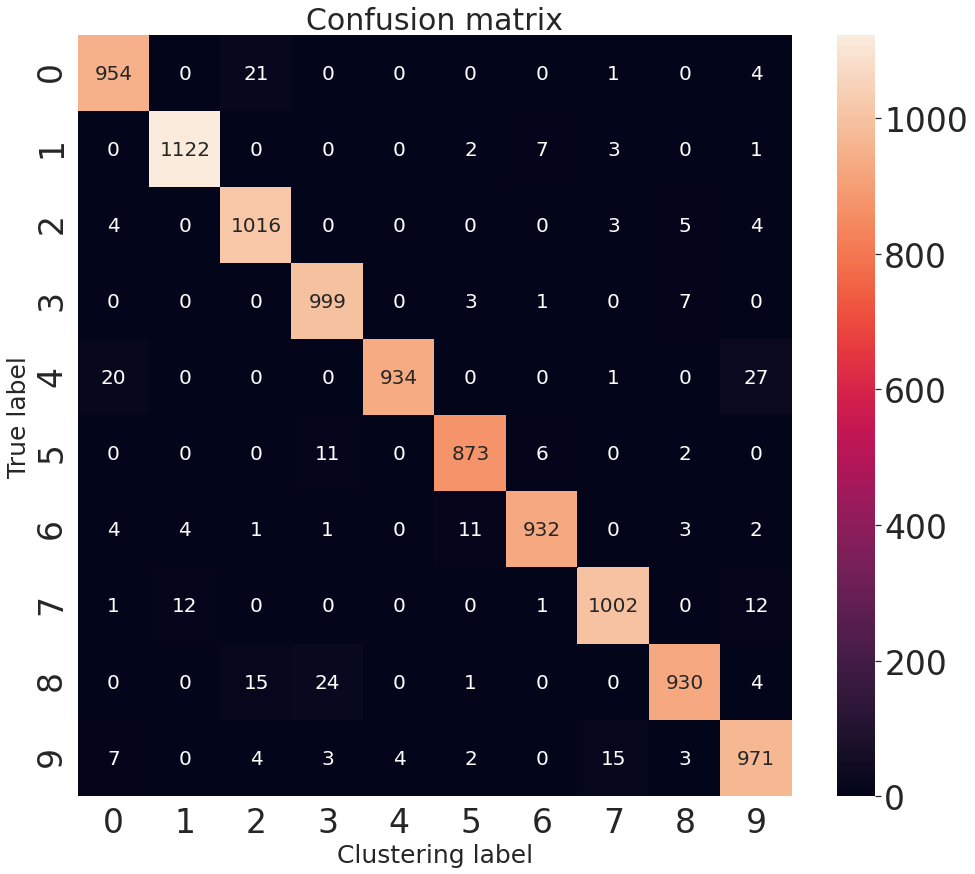

In [15]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()